<font size=6><b>Lec07.[실습] 이미지 분류(cat dog)

<img src="./imgs/lec07_logo.png">
* ref : https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/overview

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [10]:
import tensorflow as tf
tf.random.set_seed(1234)
np.random.seed(1234)

In [71]:
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D
from keras.initializers import GlorotNormal  #Xavier

# Data Load

## Image Lib.

### PIL
* img = <b>Image.open('경로')</b>
* plt.imshow(img)

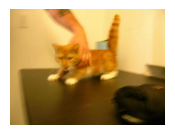

In [34]:
from PIL import Image
plt.figure(figsize=(2,2))
img = Image.open('./datasets/catdog/train/cat/cat.0.jpg')
plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.show()

### matplotlib
* img = <b>pltimg.imread('경로')</b>
* plt.imshow(img)

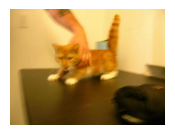

In [35]:
import matplotlib.image as pltimg
plt.figure(figsize=(2,2))
img = pltimg.imread('./datasets/catdog/train/cat/cat.0.jpg')


plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.show()

### opencv

In [40]:
# ! pip install opencv-python

In [41]:
# import cv2
# img = cv2.imread("./datasets/catdog/train/cat/cat.0.jpg", cv2.IMREAD_UNCHANGED)
# cv2.imshow("title-bar", img)
# height, width, channel = img.shape

### keras

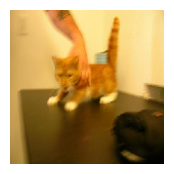

In [59]:
# from keras.preprocessing import image as ksimg
from keras.utils import load_img
plt.figure(figsize=(2,2))
img = load_img("./datasets/catdog/train/cat/cat.0.jpg", target_size=(150,150))

plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.show()

## 샘플 이미지 보기

In [29]:
import os
base_path = "./datasets/catdog/train/cat"
img_path_list = os.listdir(base_path)[:5]
print(img_path_list)

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']


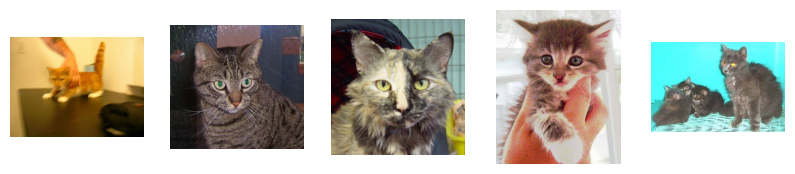

In [31]:
import matplotlib.image as pltimg
plt.figure(figsize=(10,2))

for i, fname in enumerate(img_path_list):
    plt.subplot(1, len(img_path_list), i+1)
    #------------------------------------------------------
    img = pltimg.imread(os.path.join(base_path, fname))
    #img = Image.open('./datasets/catdog/train/cat/cat.0.jpg')
    #------------------------------------------------------
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')

<pre>
-root_dir
    - train
        -cat(label)
           - ....png
           - ....png
        -dog(label)
    - test

In [39]:
print(f"train cat : {len(os.listdir('./datasets/catdog/train/cat'))}")
print(f"train dog : {len(os.listdir('./datasets/catdog/train/dog'))}")
print(f"test      : {len(os.listdir('./datasets/catdog/test/test'))}")

train cat : 301
train dog : 301
test : 50


# 전처리&가공

## 스케일링
* X_train / 255.0

## 리사이징
* X_train.resize(w,h)

## 증강
* ref : https://keras.io/ko/preprocessing/image/
<pre>
<b>flow_from_directory(directory, target_size=(256, 256), class_mode='categorical', batch_size=32,seed=None,shuffle=True, </b>
color_mode='rgb', classes=None,  
save_to_dir=None, save_prefix='', save_format='png', 
follow_links=False, subset=None, interpolation='nearest')

In [42]:
from keras.preprocessing.image import ImageDataGenerator

In [43]:
MY_WIDTH__    = 150
MY_HEIGHT__   = 150
MY_EPOCH      = 10
MY_BATCH_SIZE = 64
MY_SEED       = 1234 

In [61]:
generator = ImageDataGenerator( rotation_range=20  
                               ,zoom_range=0.1
                               ,horizontal_flip=True
                               ,vertical_flip=False 
                               ,rescale = 1. /255
                               ,validation_split=0.2)

test_generator = ImageDataGenerator(rescale = 1. /255.)


train_iter = generator.flow_from_directory(directory="./datasets/catdog/train"
                                           , target_size=(MY_WIDTH__,MY_HEIGHT__)
                                           , class_mode='binary'  # 2개폴더 cat dog
                                           , batch_size=MY_BATCH_SIZE
                                           , seed=MY_SEED
                                           , subset="training"  #subset="validation"
                                          )

val_iter   = generator.flow_from_directory(directory="./datasets/catdog/train"
                                           , target_size=(MY_WIDTH__,MY_HEIGHT__)
                                           , class_mode='binary'
                                           , batch_size=MY_BATCH_SIZE
                                           , seed=MY_SEED
                                           , subset="validation"  
                                          )

test_iter  = test_generator.flow_from_directory(directory="./datasets/catdog/test"
                                           , target_size=(MY_WIDTH__,MY_HEIGHT__)
                                           , batch_size=1
                                           , seed=MY_SEED
                                               )

Found 482 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


# 모델

In [62]:
model = Sequential()
# ------------- CNN ---------------------
model.add(Conv2D(filters=16, input_shape=(MY_WIDTH__,MY_HEIGHT__,3), kernel_size=(5,5), strides=(1, 1), padding='valid', activation='relu', kernel_initializer='glorot_uniform')  )
model.add(MaxPool2D(pool_size=(2, 2),                               strides=None  , padding="valid"))
model.add(Conv2D(filters=24, kernel_size=(5,5), activation='relu' ) )
model.add(MaxPool2D(pool_size=(2, 2) ))

# ------------- Fully Connected ---------
model.add(Flatten())

model.add(Dense(units=60,  activation='relu'))              #히든레이어
model.add(Dense(units=1,  activation='sigmoid'))            #개 아니면 고양이
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [64]:
fit_hisroty = model.fit(train_iter,
          steps_per_epoch=train_iter.samples/MY_BATCH_SIZE,  #482/64 약7
          epochs=MY_EPOCH,
          validation_data=val_iter,
          validation_steps = val_iter.samples/MY_BATCH_SIZE  #120/64 약2            
        )
# print ( model.evaluate(train_iter)  )

Epoch 1/10
7/7 [==============================] - 8s 933ms/step - loss: 0.9566 - accuracy: 0.4896 - val_loss: 0.6915 - val_accuracy: 0.5500
Epoch 2/10
7/7 [==============================] - 7s 898ms/step - loss: 0.6912 - accuracy: 0.5560 - val_loss: 0.6912 - val_accuracy: 0.5333
Epoch 3/10
7/7 [==============================] - 8s 1s/step - loss: 0.6879 - accuracy: 0.5913 - val_loss: 0.6829 - val_accuracy: 0.5417
Epoch 4/10
7/7 [==============================] - 7s 994ms/step - loss: 0.6706 - accuracy: 0.5851 - val_loss: 0.6857 - val_accuracy: 0.5333
Epoch 5/10
7/7 [==============================] - 8s 1s/step - loss: 0.6507 - accuracy: 0.6162 - val_loss: 0.6743 - val_accuracy: 0.5500
Epoch 6/10
7/7 [==============================] - 7s 981ms/step - loss: 0.6530 - accuracy: 0.6473 - val_loss: 0.6668 - val_accuracy: 0.6250
Epoch 7/10
7/7 [==============================] - 7s 983ms/step - loss: 0.6378 - accuracy: 0.6618 - val_loss: 0.6880 - val_accuracy: 0.5667
Epoch 8/10
7/7 [==========

In [65]:
model.evaluate(test_iter)

50/50 [==============================] - 1s 6ms/step - loss: 0.7332 - accuracy: 0.6200


[0.7331731915473938, 0.6200000047683716]

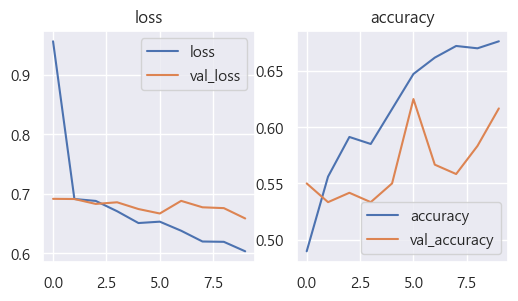

In [66]:
plt.figure(figsize=(6,3))
ax1 = plt.subplot(1,2,1)
ax1.plot(fit_hisroty.history['loss']    , label='loss')
ax1.plot(fit_hisroty.history['val_loss'], label='val_loss')
ax1.legend()
ax1.set_title("loss")

ax2 = plt.subplot(1,2,2)
ax2.plot(fit_hisroty.history['accuracy']    , label='accuracy')
ax2.plot(fit_hisroty.history['val_accuracy'], label='val_accuracy')
ax2.legend()
ax2.set_title("accuracy")

plt.show()

# 전이학습
* ref : https://keras.io/api/applications/https://keras.io/api/applications/

* 2-2. 방법2) CNN(전이학습 + ResNet Weight)  +  FC(신규, 내 데이터로 학습한 weight)  --> FC 학습시간 소요
* CNN 가중치는 imagenet 가중치 불러와서 사용
* include_top=False (FC는 신규생성해서 사용하겠다는 의미)
* 자신만의 FC구성해서 사용

<table width=700>
<thead>
<tr>
<th>Model</th>
<th style="text-align: right;">Size (MB)</th>
<th style="text-align: right;">Top-1 Accuracy</th>
<th style="text-align: right;">Top-5 Accuracy</th>
<th style="text-align: right;">Parameters</th>
<th style="text-align: right;">Depth</th>
<th style="text-align: right;">Time (ms) per inference step (CPU)</th>
<th style="text-align: right;">Time (ms) per inference step (GPU)</th>
</tr>
</thead>
<tbody>
<tr>
<td><a href="xception">Xception</a></td>
<td style="text-align: right;">88</td>
<td style="text-align: right;">79.0%</td>
<td style="text-align: right;">94.5%</td>
<td style="text-align: right;">22.9M</td>
<td style="text-align: right;">81</td>
<td style="text-align: right;">109.4</td>
<td style="text-align: right;">8.1</td>
</tr>
<tr>
<td><a href="vgg/#vgg16-function">VGG16</a></td>
<td style="text-align: right;">528</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.1%</td>
<td style="text-align: right;">138.4M</td>
<td style="text-align: right;">16</td>
<td style="text-align: right;">69.5</td>
<td style="text-align: right;">4.2</td>
</tr>
<tr>
<td><a href="vgg/#vgg19-function">VGG19</a></td>
<td style="text-align: right;">549</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.0%</td>
<td style="text-align: right;">143.7M</td>
<td style="text-align: right;">19</td>
<td style="text-align: right;">84.8</td>
<td style="text-align: right;">4.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet50-function">ResNet50</a></td>
<td style="text-align: right;">98</td>
<td style="text-align: right;">74.9%</td>
<td style="text-align: right;">92.1%</td>
<td style="text-align: right;">25.6M</td>
<td style="text-align: right;">107</td>
<td style="text-align: right;">58.2</td>
<td style="text-align: right;">4.6</td>
</tr>
<tr>
<td><a href="resnet/#resnet50v2-function">ResNet50V2</a></td>
<td style="text-align: right;">98</td>
<td style="text-align: right;">76.0%</td>
<td style="text-align: right;">93.0%</td>
<td style="text-align: right;">25.6M</td>
<td style="text-align: right;">103</td>
<td style="text-align: right;">45.6</td>
<td style="text-align: right;">4.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet101-function">ResNet101</a></td>
<td style="text-align: right;">171</td>
<td style="text-align: right;">76.4%</td>
<td style="text-align: right;">92.8%</td>
<td style="text-align: right;">44.7M</td>
<td style="text-align: right;">209</td>
<td style="text-align: right;">89.6</td>
<td style="text-align: right;">5.2</td>
</tr>
<tr>
<td><a href="resnet/#resnet101v2-function">ResNet101V2</a></td>
<td style="text-align: right;">171</td>
<td style="text-align: right;">77.2%</td>
<td style="text-align: right;">93.8%</td>
<td style="text-align: right;">44.7M</td>
<td style="text-align: right;">205</td>
<td style="text-align: right;">72.7</td>
<td style="text-align: right;">5.4</td>
</tr>
<tr>
<td><a href="resnet/#resnet152-function">ResNet152</a></td>
<td style="text-align: right;">232</td>
<td style="text-align: right;">76.6%</td>
<td style="text-align: right;">93.1%</td>
<td style="text-align: right;">60.4M</td>
<td style="text-align: right;">311</td>
<td style="text-align: right;">127.4</td>
<td style="text-align: right;">6.5</td>
</tr>
<tr>
<td><a href="resnet/#resnet152v2-function">ResNet152V2</a></td>
<td style="text-align: right;">232</td>
<td style="text-align: right;">78.0%</td>
<td style="text-align: right;">94.2%</td>
<td style="text-align: right;">60.4M</td>
<td style="text-align: right;">307</td>
<td style="text-align: right;">107.5</td>
<td style="text-align: right;">6.6</td>
</tr>
<tr>
<td><a href="inceptionv3">InceptionV3</a></td>
<td style="text-align: right;">92</td>
<td style="text-align: right;">77.9%</td>
<td style="text-align: right;">93.7%</td>
<td style="text-align: right;">23.9M</td>
<td style="text-align: right;">189</td>
<td style="text-align: right;">42.2</td>
<td style="text-align: right;">6.9</td>
</tr>
<tr>
<td><a href="inceptionresnetv2">InceptionResNetV2</a></td>
<td style="text-align: right;">215</td>
<td style="text-align: right;">80.3%</td>
<td style="text-align: right;">95.3%</td>
<td style="text-align: right;">55.9M</td>
<td style="text-align: right;">449</td>
<td style="text-align: right;">130.2</td>
<td style="text-align: right;">10.0</td>
</tr>
<tr>
<td><a href="mobilenet">MobileNet</a></td>
<td style="text-align: right;">16</td>
<td style="text-align: right;">70.4%</td>
<td style="text-align: right;">89.5%</td>
<td style="text-align: right;">4.3M</td>
<td style="text-align: right;">55</td>
<td style="text-align: right;">22.6</td>
<td style="text-align: right;">3.4</td>
</tr>
<tr>
<td><a href="mobilenet/#mobilenetv2-function">MobileNetV2</a></td>
<td style="text-align: right;">14</td>
<td style="text-align: right;">71.3%</td>
<td style="text-align: right;">90.1%</td>
<td style="text-align: right;">3.5M</td>
<td style="text-align: right;">105</td>
<td style="text-align: right;">25.9</td>
<td style="text-align: right;">3.8</td>
</tr>
<tr>
<td><a href="densenet/#densenet121-function">DenseNet121</a></td>
<td style="text-align: right;">33</td>
<td style="text-align: right;">75.0%</td>
<td style="text-align: right;">92.3%</td>
<td style="text-align: right;">8.1M</td>
<td style="text-align: right;">242</td>
<td style="text-align: right;">77.1</td>
<td style="text-align: right;">5.4</td>
</tr>
<tr>
<td><a href="densenet/#densenet169-function">DenseNet169</a></td>
<td style="text-align: right;">57</td>
<td style="text-align: right;">76.2%</td>
<td style="text-align: right;">93.2%</td>
<td style="text-align: right;">14.3M</td>
<td style="text-align: right;">338</td>
<td style="text-align: right;">96.4</td>
<td style="text-align: right;">6.3</td>
</tr>
<tr>
<td><a href="densenet/#densenet201-function">DenseNet201</a></td>
<td style="text-align: right;">80</td>
<td style="text-align: right;">77.3%</td>
<td style="text-align: right;">93.6%</td>
<td style="text-align: right;">20.2M</td>
<td style="text-align: right;">402</td>
<td style="text-align: right;">127.2</td>
<td style="text-align: right;">6.7</td>
</tr>
<tr>
<td><a href="nasnet/#nasnetmobile-function">NASNetMobile</a></td>
<td style="text-align: right;">23</td>
<td style="text-align: right;">74.4%</td>
<td style="text-align: right;">91.9%</td>
<td style="text-align: right;">5.3M</td>
<td style="text-align: right;">389</td>
<td style="text-align: right;">27.0</td>
<td style="text-align: right;">6.7</td>
</tr>
<tr>
<td><a href="nasnet/#nasnetlarge-function">NASNetLarge</a></td>
<td style="text-align: right;">343</td>
<td style="text-align: right;">82.5%</td>
<td style="text-align: right;">96.0%</td>
<td style="text-align: right;">88.9M</td>
<td style="text-align: right;">533</td>
<td style="text-align: right;">344.5</td>
<td style="text-align: right;">20.0</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb0-function">EfficientNetB0</a></td>
<td style="text-align: right;">29</td>
<td style="text-align: right;">77.1%</td>
<td style="text-align: right;">93.3%</td>
<td style="text-align: right;">5.3M</td>
<td style="text-align: right;">132</td>
<td style="text-align: right;">46.0</td>
<td style="text-align: right;">4.9</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb1-function">EfficientNetB1</a></td>
<td style="text-align: right;">31</td>
<td style="text-align: right;">79.1%</td>
<td style="text-align: right;">94.4%</td>
<td style="text-align: right;">7.9M</td>
<td style="text-align: right;">186</td>
<td style="text-align: right;">60.2</td>
<td style="text-align: right;">5.6</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb2-function">EfficientNetB2</a></td>
<td style="text-align: right;">36</td>
<td style="text-align: right;">80.1%</td>
<td style="text-align: right;">94.9%</td>
<td style="text-align: right;">9.2M</td>
<td style="text-align: right;">186</td>
<td style="text-align: right;">80.8</td>
<td style="text-align: right;">6.5</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb3-function">EfficientNetB3</a></td>
<td style="text-align: right;">48</td>
<td style="text-align: right;">81.6%</td>
<td style="text-align: right;">95.7%</td>
<td style="text-align: right;">12.3M</td>
<td style="text-align: right;">210</td>
<td style="text-align: right;">140.0</td>
<td style="text-align: right;">8.8</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb4-function">EfficientNetB4</a></td>
<td style="text-align: right;">75</td>
<td style="text-align: right;">82.9%</td>
<td style="text-align: right;">96.4%</td>
<td style="text-align: right;">19.5M</td>
<td style="text-align: right;">258</td>
<td style="text-align: right;">308.3</td>
<td style="text-align: right;">15.1</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb5-function">EfficientNetB5</a></td>
<td style="text-align: right;">118</td>
<td style="text-align: right;">83.6%</td>
<td style="text-align: right;">96.7%</td>
<td style="text-align: right;">30.6M</td>
<td style="text-align: right;">312</td>
<td style="text-align: right;">579.2</td>
<td style="text-align: right;">25.3</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb6-function">EfficientNetB6</a></td>
<td style="text-align: right;">166</td>
<td style="text-align: right;">84.0%</td>
<td style="text-align: right;">96.8%</td>
<td style="text-align: right;">43.3M</td>
<td style="text-align: right;">360</td>
<td style="text-align: right;">958.1</td>
<td style="text-align: right;">40.4</td>
</tr>
<tr>
<td><a href="efficientnet/#efficientnetb7-function">EfficientNetB7</a></td>
<td style="text-align: right;">256</td>
<td style="text-align: right;">84.3%</td>
<td style="text-align: right;">97.0%</td>
<td style="text-align: right;">66.7M</td>
<td style="text-align: right;">438</td>
<td style="text-align: right;">1578.9</td>
<td style="text-align: right;">61.6</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b0-function">EfficientNetV2B0</a></td>
<td style="text-align: right;">29</td>
<td style="text-align: right;">78.7%</td>
<td style="text-align: right;">94.3%</td>
<td style="text-align: right;">7.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b1-function">EfficientNetV2B1</a></td>
<td style="text-align: right;">34</td>
<td style="text-align: right;">79.8%</td>
<td style="text-align: right;">95.0%</td>
<td style="text-align: right;">8.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b2-function">EfficientNetV2B2</a></td>
<td style="text-align: right;">42</td>
<td style="text-align: right;">80.5%</td>
<td style="text-align: right;">95.1%</td>
<td style="text-align: right;">10.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2b3-function">EfficientNetV2B3</a></td>
<td style="text-align: right;">59</td>
<td style="text-align: right;">82.0%</td>
<td style="text-align: right;">95.8%</td>
<td style="text-align: right;">14.5M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2s-function">EfficientNetV2S</a></td>
<td style="text-align: right;">88</td>
<td style="text-align: right;">83.9%</td>
<td style="text-align: right;">96.7%</td>
<td style="text-align: right;">21.6M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2m-function">EfficientNetV2M</a></td>
<td style="text-align: right;">220</td>
<td style="text-align: right;">85.3%</td>
<td style="text-align: right;">97.4%</td>
<td style="text-align: right;">54.4M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="efficientnet_v2/#efficientnetv2l-function">EfficientNetV2L</a></td>
<td style="text-align: right;">479</td>
<td style="text-align: right;">85.7%</td>
<td style="text-align: right;">97.5%</td>
<td style="text-align: right;">119.0M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnexttiny-function">ConvNeXtTiny</a></td>
<td style="text-align: right;">109.42</td>
<td style="text-align: right;">81.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">28.6M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextsmall-function">ConvNeXtSmall</a></td>
<td style="text-align: right;">192.29</td>
<td style="text-align: right;">82.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">50.2M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextbase-function">ConvNeXtBase</a></td>
<td style="text-align: right;">338.58</td>
<td style="text-align: right;">85.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">88.5M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextlarge-function">ConvNeXtLarge</a></td>
<td style="text-align: right;">755.07</td>
<td style="text-align: right;">86.3%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">197.7M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
<tr>
<td><a href="convnext/#convnextxlarge-function">ConvNeXtXLarge</a></td>
<td style="text-align: right;">1310</td>
<td style="text-align: right;">86.7%</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">350.1M</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
<td style="text-align: right;">-</td>
</tr>
</tbody>
</table>

In [68]:
from keras.applications import ResNet50

* FC (분류기) : include_top

In [69]:
base_model = ResNet50(include_top=False               #FC         : 자가구성
                      , weights='imagenet'            #CNN-weight : ResNet
                      , input_shape=(MY_WIDTH__,MY_HEIGHT__, 3))
base_model.summary()

94765736/94765736 [==============================] - 8s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [74]:
model = Sequential()
model.add(base_model)  
#===============include_top=False (FC는 신규생성해서 사용하겠다는 의미)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=60,  activation='relu'))              #히든레이어
model.add(Dense(units=1,  activation='sigmoid'))            #개 아니면 고양이
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 60)                122940    
                                                                 
 dense_7 (Dense)             (None, 1)                 61        
                                                                 
Total params: 23,710,713
Trainable params: 23,657,593
Non-trainable params: 53,120
_________________________________________________________________


In [75]:
fit_hisroty = model.fit(train_iter,
          steps_per_epoch=train_iter.samples/MY_BATCH_SIZE,  #482/64 약7
          epochs=MY_EPOCH,
          validation_data=val_iter,
          validation_steps = val_iter.samples/MY_BATCH_SIZE  #120/64 약2            
        )


Epoch 1/10
7/7 [==============================] - 114s 13s/step - loss: 0.4552 - accuracy: 0.8174 - val_loss: 134.0198 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 97s 13s/step - loss: 0.3147 - accuracy: 0.8693 - val_loss: 377.6119 - val_accuracy: 0.5000
Epoch 3/10
7/7 [==============================] - 95s 13s/step - loss: 0.3050 - accuracy: 0.8838 - val_loss: 488.3659 - val_accuracy: 0.5000
Epoch 4/10
7/7 [==============================] - 96s 13s/step - loss: 0.2570 - accuracy: 0.8942 - val_loss: 225.3108 - val_accuracy: 0.5000
Epoch 5/10
7/7 [==============================] - 90s 12s/step - loss: 0.1503 - accuracy: 0.9398 - val_loss: 0.6934 - val_accuracy: 0.5333
Epoch 6/10
7/7 [==============================] - 88s 12s/step - loss: 0.1265 - accuracy: 0.9564 - val_loss: 0.7223 - val_accuracy: 0.5000
Epoch 7/10
7/7 [==============================] - 87s 12s/step - loss: 0.1078 - accuracy: 0.9523 - val_loss: 0.9910 - val_accuracy: 0.5000
Epoch 8/10
7/7 [==

In [76]:
model.evaluate(test_iter)

50/50 [==============================] - 5s 65ms/step - loss: 15.4249 - accuracy: 0.0000e+00


[15.424943923950195, 0.0]

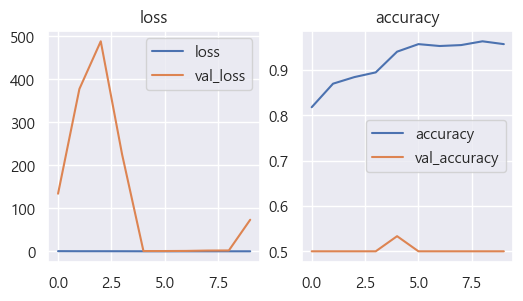

In [77]:
plt.figure(figsize=(6,3))
ax1 = plt.subplot(1,2,1)
ax1.plot(fit_hisroty.history['loss']    , label='loss')
ax1.plot(fit_hisroty.history['val_loss'], label='val_loss')
ax1.legend()
ax1.set_title("loss")

ax2 = plt.subplot(1,2,2)
ax2.plot(fit_hisroty.history['accuracy']    , label='accuracy')
ax2.plot(fit_hisroty.history['val_accuracy'], label='val_accuracy')
ax2.legend()
ax2.set_title("accuracy")

plt.show()